# Hinglish Sarcasm Detection System

In [ ]:
#!pip install fasttext
#!pip install FastText
#!pip install imblearn
# import fasttext.util
# import fasttext
# from imblearn import over_sampling
# from nltk.tokenize import word_tokenize


In [1]:
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import itertools

#To Try different various hyptermeters
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.model_selection import GridSearchCV

#Algo to use for modelling
from sklearn.linear_model import LogisticRegression
import lightgbm as lgbm
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier,  GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import RFE
#from sklearn.tree import DecisionTreeClassifier


#To Mearure Performance of Model
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import  sklearn.metrics as metrics

run_cv=False 
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)

# A- Create Embedding
Different embedding are created in different programs

# B- Read an Emebedding for Modelling

In [49]:
#paths required
datafolder_p = r'D:\18-DS\github\SDSHL\data\processed'
datafolder_e = r'D:\18-DS\github\SDSHL\data\external'
datafolder_i = r'D:\18-DS\github\SDSHL\data\internal'
modelfolder  = r'D:\18-DS\data\models'

file_train = datafolder_p + r'\2-train.csv'
file_test = datafolder_p + r'\2-test.csv'

embed_name={
1: 'tfidf'             ,
2: 'word2vec'          ,
3: 'bow'               ,
4: 'bert_indicnlp'     ,
5: 'bert_multiling'    ,
6: 'fasttext'          ,
7: 'fasttext_indicnlp' ,
8: 'fastext_wiki'      ,
}

#These file names without end train & test and .csv (extention)
embed_file={
'tfidf'             : r'\embedding_tfidf.csv',
'word2vec'          : r'\embedding_w2v.csv',
'bow'               : r'\embedding_bow.csv',
'bert_indicnlp'     : r'\embedding_bert768_indicnlp_pretrained.csv',
'bert_multiling'    : r'\embedding_bert768_mbert_pretrained.csv',
'fasttext'          : r'\embedding_ft_local.csv',
'fasttext_indicnlp' : r'\embedding_ft300_indicnlp_pretrained.csv',
'fastext_wiki'      : r'\embedding_ft300_wiki_pretrained.csv'
}

prediction={}

### <font color=red> Choose Embedding Number</font>

In [66]:
embed_number=8
print (embed_name[embed_number])

file_data = datafolder_p +  embed_file[ embed_name[embed_number] ]
df = pd.read_csv(file_data, index_col="ID")

fastext_wiki


# C- Test Train Split

In [67]:
#This strategy of test train split is taken to ensure that all embedding has same set of records
df_train =  pd.read_csv(file_train, index_col="ID", sep='\t')
df_test  =  pd.read_csv(file_test, index_col="ID", sep='\t')
idx_train = list(df_train.index)
idx_test  = list(df_test.index)

X_train = df.loc[ idx_train,]
X_val  = df.loc[ idx_test,]

y_train1 = X_train['label']
y_val1   = X_val['label']
X_train1 = X_train.drop(columns=['label'])
X_val1  = X_val.drop(columns=['label'])

print( X_train1.shape, X_val1.shape, y_train1.shape, y_val1.shape)

(2083, 300) (232, 300) (2083,) (232,)


### <font color=red> Oversampling causing index identification problem for predicted records</font>

In [84]:
model_with_data_list=['Normal','RandomOverSampler','Smote','AdaSyn']
# option=-1
# while not (option>=0 and option<=3):
#     i = input('0-Normal, 1-RandomOverSampler, 2-Smote, 3-AdaSyn ')
#     try:
#         option=int(i)
#     except:
#         option=-1    

option = 0

if option==1:
    ros = over_sampling.RandomOverSampler(random_state=100)
    X_train_ros, y_train_ros       = ros.fit_resample(X_train1, y_train1)
    X_val_ros,  y_val_ros        = ros.fit_resample(X_val1, y_val1)
elseif option==2:
    smt = over_sampling.SMOTE(random_state=100)
    X_train_smote, y_train_smote   = smt.fit_resample(X_train1, y_train1)
    X_val_smote,  y_val_smote    = smt.fit_resample(X_val1, y_val1)
elseif option==3:
    ada = over_sampling.ADASYN(random_state=100)
    X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train1, y_train1)
    X_val_adasyn,  y_val_adasyn  = ada.fit_resample(X_val1, y_val1)

'Normal'

In [68]:
if option==0:
    X_train, X_val, y_train, y_val = X_train1, X_val1, y_train1, y_val1
elif option==1:
    X_train, X_val, y_train, y_val = X_train_ros, X_val_ros, y_train_ros , y_val_ros
elif option==2:
    X_train, X_val, y_train, y_val = X_train_smote, X_val_smote, y_train_smote , y_val_smote
elif option==3:
    X_train, X_val, y_train, y_val = X_train_adasyn, X_val_adasyn, y_train_adasyn , y_val_adasyn
    
print ( 'Oversampling Technique Used:' + model_with_data_list[option])
print( X_train.shape, X_val.shape, y_train.shape, y_val.shape)

Oversampling Technique Used: Option 0: Without Oversampling
(2083, 300) (232, 300) (2083,) (232,)


# D- Common Function for Classification Model

### Confusion Matrix Plotting

In [6]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### draw_cv_results

In [7]:
# Plotting cv results
def draw_cv_results(cv_df, param_name, metric_name, title_name, log_true):
    plt.figure(figsize=(10,4))
    
    if log_true:
        x_axis= np.log10( list(cv_df[param_name]))
        x_axis_title = "Log Value "+param_name
    else:
        x_axis = list(cv_df[param_name])
        x_axis_title = param_name
        
    plt.plot( x_axis, cv_df['mean_train_score'] )
    plt.plot( x_axis, cv_df['mean_test_score'] )
    plt.xlabel(x_axis_title)
    plt.ylabel(metric_name)
    plt.title(title_name)
    plt.legend(['Train ' + metric_name +' score', 'Test ' +metric_name+' score'], loc='upper left')


### draw_confusion_matrix

In [8]:
# Function to plot the confusion Matrix
def draw_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.tab10):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
   
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = 'd' 
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.fill(j,i,facecolor="red" if cm[i, j] < thresh else "blue", edgecolor='b', linewidth=2)
        #plt.Rectangle((0, 0), 1, 0, linewidth=1, edgecolor='b', facecolor='none')
        
        plt.text(j, i, format(cm[i, j], fmt), fontsize=20, weight="bold", 
                 verticalalignment='center',
                 horizontalalignment="center",
                 color="white", 
                 
                bbox=dict(facecolor='red', alpha=0.8))

    plt.tight_layout()
    plt.ylabel('True label',fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)

### draw_roc

In [9]:
class_names=[0,1]

def draw_roc( actual, probs, prob_values=True, Threshold_limit=0.4, pred_colname='Unknown' ):
  
    print (pred_colname)
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                          drop_intermediate = False )
    
    threshold = thresholds[np.argmax(tpr-fpr)]

    if prob_values:
        pred= probs.map(lambda x: 1 if x > threshold else 0)
    else:
        pred= probs
    
    prediction[ pred_colname ] = probs
    
    auc_score = round( metrics.roc_auc_score( actual, probs) ,2)
    
    recall    = round( metrics.recall_score(actual,pred),2)
    precision = round(metrics.precision_score(actual, pred),2)
    accuracy  = round(metrics.accuracy_score(actual,pred),2)
    f1= round(metrics.f1_score(actual,pred),2)
    

    plt.figure(figsize=(20, 5))
    plt.subplot(1,2,1)
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]',fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver operating characteristic example',fontsize=20)
    plt.legend(loc="lower right")
    
    plt.subplot(1,2,2)
    cm = confusion_matrix(actual, pred)
    draw_confusion_matrix(cm,class_names)
    plt.show()
    
    print ("This Model Result is for ", model_with_data_list[option], " Data")
    print ("ROC AUC Score on Test:",auc_score," Threshold:{:.5f}".format(threshold))
    print ("Accuracy",accuracy,"AUC:",auc_score,"Recall:",recall,"Precision:",precision,"F1:",f1)
    return accuracy,auc_score,recall,precision,f1

# E- Create Classification Model

In [10]:
print( X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(2083, 15) (232, 15) (2083,) (232,)


## 1- LogisticRegression Model

In [ ]:
run_cv=False
X_train.shape,y_train.shape

In [ ]:
# Cross validation using different values of C. Let's check which value of C gives best result
start=timer()
if run_cv:
    hyper_params = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }]

    lr = LogisticRegression(max_iter=1000, random_state=100)
    lr.fit(X_train, y_train)      

    model_cv_logistic = GridSearchCV(estimator=lr, param_grid=hyper_params, \
                            cv=folds, scoring="roc_auc", return_train_score=True, verbose=True)
    model_cv_logistic.fit(X_train,  y_train)

    cv_results_lr = pd.DataFrame(model_cv_logistic.cv_results_)
    print(cv_results_lr)
    
end = timer()
print("Duration ",end - start)

In [ ]:
if run_cv:
    draw_cv_results(cv_results_lr, 'param_C', 'ROC AUC', 'Optimal C', True)
    
if run_cv:
    model_cv_logistic.best_estimator_

In [11]:
def process_model_LR(pred_colname):
#     #There are 29 variables in X_train. Let's see can we manage good result with lessor variables.
#     if option==0 or option==1:
#         lr = LogisticRegression(C=.1,max_iter=1000, random_state=100) #Value of C & max_iter from earlier steps #for normal
#     elif option==2:
#         lr = LogisticRegression(C=10,max_iter=1000, random_state=100) #Value of C & max_iter from earlier steps #for smote
#     else:
#         lr = LogisticRegression(C=100,max_iter=1000, random_state=100) #Value of C & max_iter from earlier steps #for adasyn
#     rfe = RFE(lr,15) #Identify top 15 important variables
#     rfe.fit(X_train,y_train)
#     useful_cols = X_train.columns[rfe.support_]
#     #print ("Useful Columns: " ,useful_cols)


#     #Hyperparameter Turning of LogisticRegression
#     #Train the model with only 15 variables (identified in earlier step)

#     X_train_= X_train[useful_cols]
#     X_val_ = X_val[useful_cols]
    
    lr = LogisticRegression(C=.01,max_iter=1000, random_state=100)
    print(X_train.shape, y_train.shape)
    lr.fit(X_train,y_train)

    y_val_pred_logistic = lr.predict_proba(X_val)
    y_val_pred_logistic = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_logistic[:,1:2].reshape(-1) })

    #check ROC_AUC Score on Test
    logistic_acc, logistic_auc_val, logistic_recall_val, logistic_precision_val, logistic_f1_val = \
                            draw_roc(y_val_pred_logistic.Class, y_val_pred_logistic.Class_Prob, True, 0.4, pred_colname)


In [ ]:
process_model_LR( embed_name[embed_number]+'_LR')

## 2- Light GradientBoost Classifier

In [ ]:
# Cross validation using different values of n_estimators.
start=timer()
if run_cv:
    hyper_params=[{  'n_estimators': range(10,110,10)  }]

    lgbm_clf = lgbm.LGBMClassifier(random_state=100)
    model_cv_lgbm = GridSearchCV(estimator=lgbm_clf, param_grid=hyper_params,
                            cv=folds, scoring="roc_auc", return_train_score=True, verbose=True)
    model_cv_lgbm.fit(X_train,  y_train)

    cv_results_lbgm = pd.DataFrame(model_cv_lgbm.cv_results_)
    cv_results_lbgm.sort_values('rank_test_score')

end = timer()
print("Duration ",end - start)

In [ ]:
if run_cv:
    draw_cv_results(cv_results_lbgm, 'param_n_estimators', 'ROC AUC', 'Optimal n_estimator', False)

In [ ]:
if run_cv:
    print(model_cv_lgbm.best_estimator_)

In [ ]:
#!pip install lightgbm 

In [12]:
def process_model_LGBM(pred_colname):
#Hyperparamter Tuning
    #lgbmc = lgbm.LGBMClassifier(n_estimators=100, random_state = 42)
    lgbmc = lgbm.LGBMClassifier(colsample_bytree=1.0,
                   importance_type='split', learning_rate=0.1, max_depth=-1,
                   min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                   n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                   random_state=100, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                   subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

    lgbmc.fit(X_train, y_train) 

    y_val_pred_lgbmc = lgbmc.predict_proba(X_val)[:,1:2].reshape(-1)
    y_val_pred_lgbmc = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_lgbmc  }) #.reshape(-1)

    lgbmc_accuracy_val, lgbmc_auc_val, lgbmc_recall_val, lgbmc_precision_val, lgbmc_f1_val = \
                            draw_roc(y_val_pred_lgbmc.Class, y_val_pred_lgbmc.Class_Prob,True,.5,pred_colname)

In [ ]:
process_model_LGBM( embed_name[embed_number]+'_LGBM')

## 3-Naive Bayesian Model

In [13]:
def process_model_NB(pred_colname):
    #Hyperparamter Tuning
    #lgbmc = lgbm.LGBMClassifier(n_estimators=100, random_state = 42)
    nb = GaussianNB()

    nb.fit(X_train, y_train) 

    y_val_pred_nb = nb.predict_proba(X_val)[:,1:2].reshape(-1)
    y_val_pred_nb = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_nb  }) #.reshape(-1)

    nb_accuracy_val, nb_auc_val, nb_recall_val, nb_precision_val, nb_f1_val = \
                            draw_roc(y_val_pred_nb.Class, y_val_pred_nb.Class_Prob,True,.5,pred_colname)

In [ ]:
process_model_NB( embed_name[embed_number]+'_LB')

## 4-GradientBoosting Model

In [ ]:
# Cross validation using different values of n_estimators.
start=timer()
if run_cv:
    hyper_params=[{  'n_estimators': range(10,110,10)  }]

    gbc = GradientBoostingClassifier(random_state=100)
    model_cv_gbc = GridSearchCV(estimator=gbc, param_grid=hyper_params,
                            cv=folds, scoring="roc_auc", return_train_score=True, verbose=True)
    model_cv_gbc.fit(X_train,  y_train)

    cv_results_gbc = pd.DataFrame(model_cv_gbc.cv_results_)
    cv_results_gbc.sort_values('rank_test_score')

end = timer()
print("Duration ",end - start)

In [ ]:
if run_cv:
    draw_cv_results(cv_results_gbc, 'param_n_estimators', 'ROC AUC', 'Optimal n_estimator', False)

In [ ]:
if run_cv:
    print(model_cv_gbc.best_estimator_)

In [14]:
def process_model_GBC(pred_colname):
    gbc = GradientBoostingClassifier() 


    #Hyperparamter Tuning
    #gbc = GradientBoostingClassifier( random_state=100)
    gbc = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                               learning_rate=0.1, loss='deviance', max_depth=3,
                               max_features=None, max_leaf_nodes=None,
                               min_impurity_decrease=0.0, min_impurity_split=None,
                               min_samples_leaf=1, min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=100,
                               n_iter_no_change=None, presort='deprecated',
                               random_state=100, subsample=1.0, tol=0.0001,
                               validation_fraction=0.1, verbose=0,
                               warm_start=False)

    gbc.fit(X_train, y_train) 

    y_val_pred_gbc = gbc.predict_proba(X_val)[:,1:2].reshape(-1)
    y_val_pred_gbc = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_gbc  }) #.reshape(-1)

    gbc_accuracy_val, gbc_auc_val, gbc_recall_val, gbc_precision_val, gbc_f1_val = \
                            draw_roc(y_val_pred_gbc.Class, y_val_pred_gbc.Class_Prob,True, .5, pred_colname)

In [ ]:
process_model_GBC( embed_name[embed_number]+'_GBC')

## 5-RandomForest Model

In [15]:
def process_model_RFC(pred_colname):
    rfc = RandomForestClassifier() 

    #Hyperparamter Tuning
    rfc = RandomForestClassifier( random_state=100)
    rfc.fit(X_train, y_train) 

    y_val_pred_rfc = rfc.predict_proba(X_val)[:,1:2].reshape(-1)
    y_val_pred_rfc = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_rfc  }) #.reshape(-1)

    rfc_accuracy_val, rfc_auc_val, rfc_recall_val, rfc_precision_val, rfc_f1_val = \
                            draw_roc(y_val_pred_rfc.Class, y_val_pred_rfc.Class_Prob,True,.5, pred_colname)

In [ ]:
process_model_RFC( embed_name[embed_number]+'_RFC')

## 6-AdaBoost Model

In [16]:
def process_model_ADB(pred_colname):

    #Hyperparamter Tuning
    adbc = AdaBoostClassifier( random_state=100)
    adbc.fit(X_train, y_train) 

    y_val_pred_adbc = adbc.predict_proba(X_val)[:,1:2].reshape(-1)
    y_val_pred_adbc = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_adbc  }) #.reshape(-1)

    adbc_accuracy_val, adbc_auc_val, adbc_recall_val, adbc_precision_val, adbc_f1_val = \
                            draw_roc(y_val_pred_adbc.Class, y_val_pred_adbc.Class_Prob,True,.5,pred_colname)

In [ ]:
process_model_ADB( embed_name[embed_number]+'_ADB')

## 7-SVC Model

In [17]:
def process_model_SVC(pred_colname):
    svc = SVC()

    #Hyperparamter Tuning
    svc = SVC( random_state=100, probability=True)
    svc.fit(X_train, y_train) 

    y_val_pred_svc = svc.predict_proba(X_val)[:,1:2].reshape(-1)
    y_val_pred_svc = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_svc  }) #.reshape(-1)

    svc_accuracy_val, svc_auc_val, svc_recall_val, svc_precision_val, svc_f1_val = \
                            draw_roc(y_val_pred_svc.Class, y_val_pred_svc.Class_Prob,True, .5, pred_colname)

In [ ]:
process_model_SVC( embed_name[embed_number]+'_SVC')

# <font color=red> Process All Models </font>

(2083, 300) (2083,)
fastext_wiki_LR


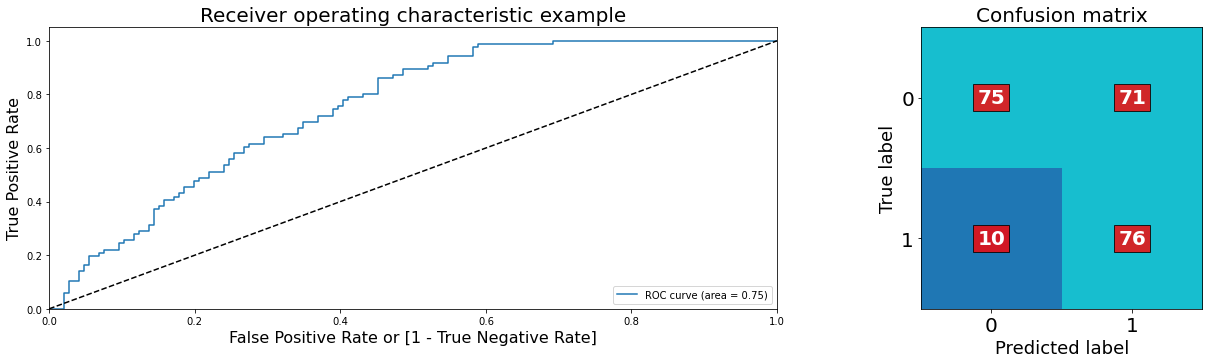

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.75  Threshold:0.34412
Accuracy 0.65 AUC: 0.75 Recall: 0.88 Precision: 0.52 F1: 0.65
fastext_wiki_LGBM


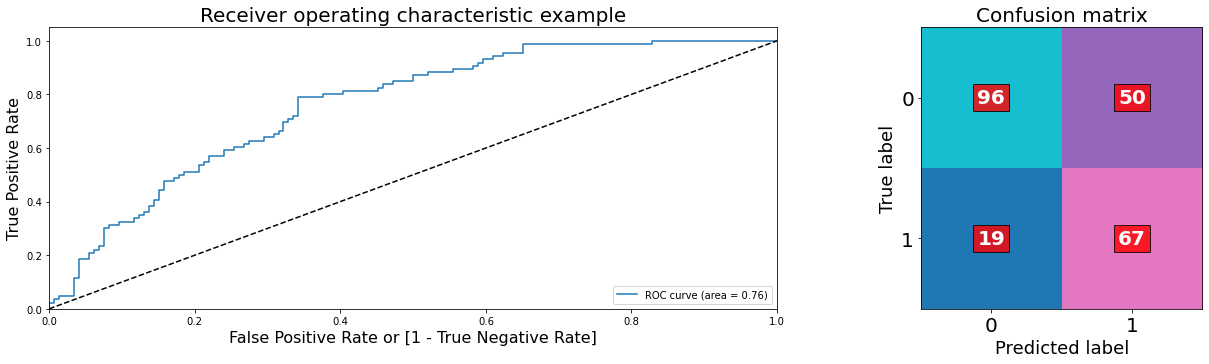

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.76  Threshold:0.06920
Accuracy 0.7 AUC: 0.76 Recall: 0.78 Precision: 0.57 F1: 0.66
fastext_wiki_NB


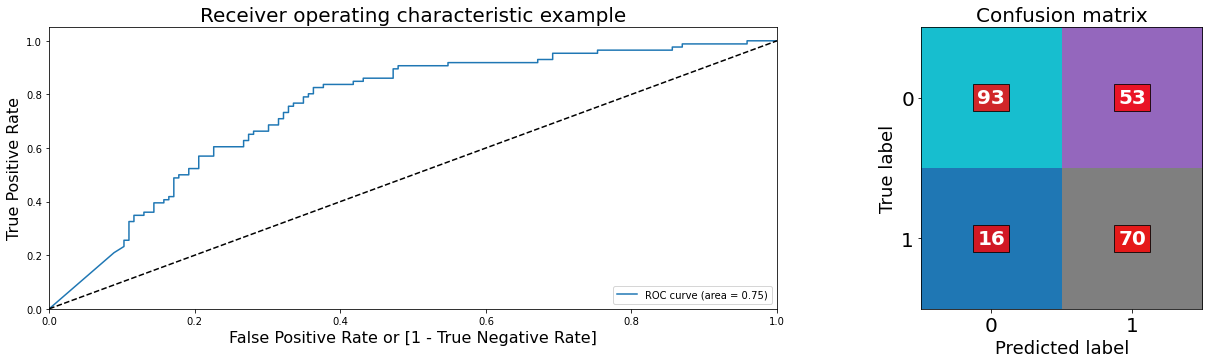

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.75  Threshold:0.00763
Accuracy 0.7 AUC: 0.75 Recall: 0.81 Precision: 0.57 F1: 0.67
fastext_wiki_SVC


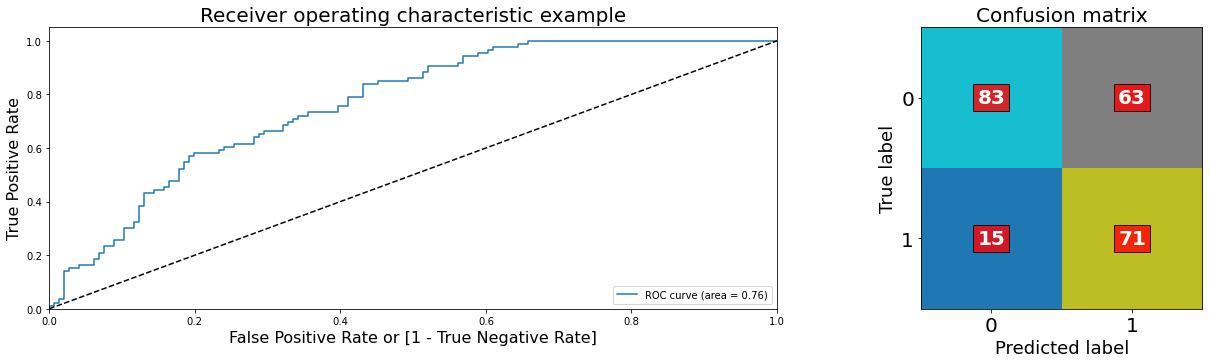

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.76  Threshold:0.07539
Accuracy 0.66 AUC: 0.76 Recall: 0.83 Precision: 0.53 F1: 0.65
fastext_wiki_ADB


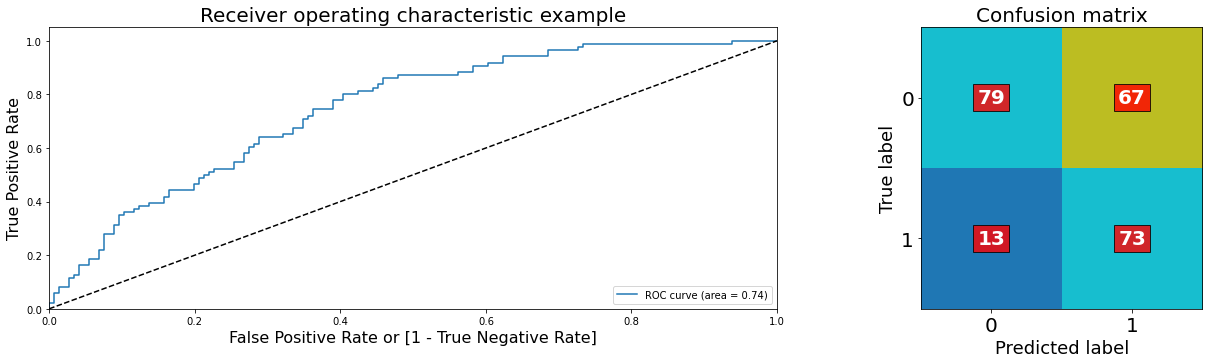

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.74  Threshold:0.47934
Accuracy 0.66 AUC: 0.74 Recall: 0.85 Precision: 0.52 F1: 0.65
fastext_wiki_GBC


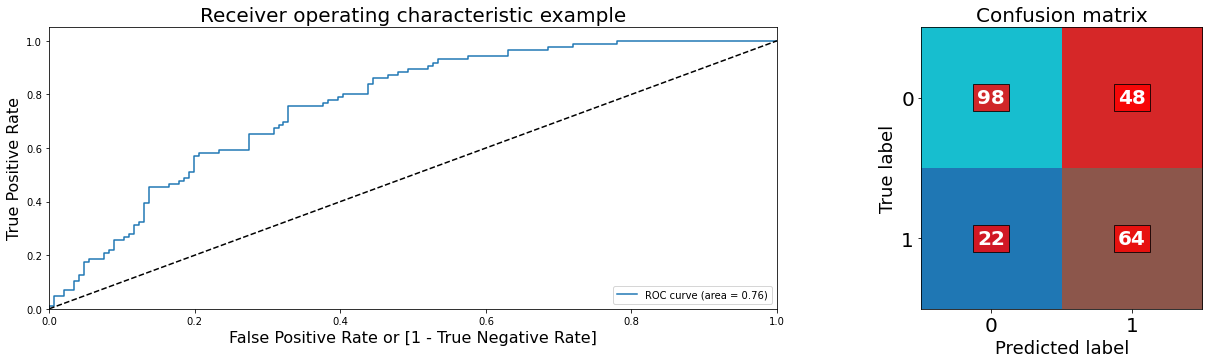

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.76  Threshold:0.21680
Accuracy 0.7 AUC: 0.76 Recall: 0.74 Precision: 0.57 F1: 0.65
fastext_wiki_RFC


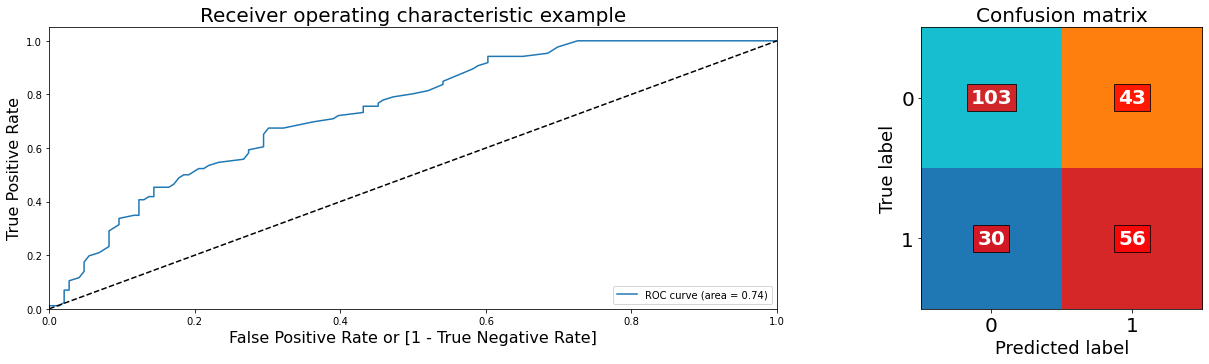

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.74  Threshold:0.39000
Accuracy 0.69 AUC: 0.74 Recall: 0.65 Precision: 0.57 F1: 0.61


In [69]:
process_model_LR( embed_name[embed_number]+'_LR')
process_model_LGBM( embed_name[embed_number]+'_LGBM')
process_model_NB( embed_name[embed_number]+'_NB')
process_model_SVC( embed_name[embed_number]+'_SVC')
process_model_ADB( embed_name[embed_number]+'_ADB')
process_model_GBC( embed_name[embed_number]+'_GBC')
process_model_RFC( embed_name[embed_number]+'_RFC')

In [70]:
df_prediction = pd.DataFrame(prediction)
#df_prediction.shape
df_prediction = df_prediction.set_index(X_val.index)
df_prediction['label'] = y_val
#y_val

In [71]:
df_prediction.to_csv(datafolder_p + r'\model_predictions_'+model_with_data_list[0]+'.csv', sep="\t")

In [72]:
df_prediction

,tfidf_LR,tfidf_LGBM,tfidf_NB,tfidf_SVC,tfidf_ADB,tfidf_GBC,tfidf_RFC,word2vec_LR,word2vec_LGBM,word2vec_NB,...,fasttext_indicnlp_GBC,fasttext_indicnlp_RFC,fastext_wiki_LR,fastext_wiki_LGBM,fastext_wiki_NB,fastext_wiki_SVC,fastext_wiki_ADB,fastext_wiki_GBC,fastext_wiki_RFC,label
ID,,,,,,,,,,,,,,,,,,,,,
5673,0.370863,0.347355,0.207820,0.405578,0.508991,0.819995,0.47,0.269828,0.090677,0.399866,...,0.036022,0.15,0.287408,0.004159,3.953982e-31,0.010474,0.426969,0.037505,0.23,0
6034,0.360636,0.475587,0.103582,0.380381,0.495742,0.574792,0.42,0.301897,0.177571,0.401967,...,0.079750,0.22,0.302914,0.002783,4.853890e-23,0.005371,0.452769,0.020732,0.21,0
81,0.367120,0.262047,0.327713,0.335283,0.495345,0.414293,0.31,0.326833,0.217676,0.000016,...,0.904780,0.59,0.393457,0.062523,1.066054e-13,0.146710,0.494194,0.279452,0.35,0
2554,0.357199,0.123473,0.078301,0.369529,0.499464,0.481535,0.31,0.221807,0.027685,0.067445,...,0.003965,0.05,0.230754,0.000162,2.602910e-37,0.000028,0.425867,0.002986,0.03,0
2784,0.373346,0.385736,0.431804,0.415590,0.496688,0.409598,0.49,0.295592,0.069086,0.535445,...,0.055741,0.22,0.326163,0.001300,1.036924e-09,0.026609,0.476663,0.030728,0.13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,0.363162,0.122906,0.199241,0.338171,0.495147,0.253858,0.22,0.314509,0.193663,0.012609,...,0.726900,0.38,0.324444,0.021595,5.237976e-14,0.006201,0.470826,0.065137,0.33,0
8866,0.376158,0.519512,0.587946,0.524961,0.493384,0.459416,0.56,0.428664,0.387553,0.076685,...,0.941318,0.72,0.481311,0.986924,1.000000e+00,0.999984,0.537673,0.958809,0.71,1
6478,0.377467,0.155748,0.772926,0.434591,0.496287,0.688201,0.44,0.388742,0.543689,0.717763,...,0.034392,0.08,0.316524,0.000826,1.253839e-06,0.005065,0.450825,0.013137,0.12,0


In [3]:
#df_prediction.shape[1]-1

In [80]:
tot_models

56

In [81]:
tot_models=df_prediction.shape[1]-1
results = np.zeros( (tot_models,5) )

threshold= 0.5
final_label = lambda x: 1 if x>threshold else 0

y_act= df_prediction.iloc[:, tot_models]
model_name=[]
for i in range(tot_models):
    model_name.append( df_prediction.columns[i])
    y_pre= df_prediction.iloc[:,i].apply(final_label)
    
    results[i][0] = np.round( metrics.accuracy_score(y_act,y_pre), 2)
    results[i][1] = np.round( metrics.recall_score(y_act,y_pre), 2)
    results[i][2] = np.round( metrics.precision_score(y_act,y_pre), 2)
    results[i][3] = np.round( metrics.f1_score(y_act,y_pre), 2)
    results[i][4] = np.round( metrics.roc_auc_score(y_act,y_pre), 2)

D:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [82]:
results1 = pd.DataFrame(results,columns=['Accuracy','Recall','Precision','F1','AUC'], index=model_name)

In [83]:
results1.to_csv(datafolder_p + r'\model_results_'+model_with_data_list[0]+'.csv', sep="\t")
results1

,Accuracy,Recall,Precision,F1,AUC
tfidf_LR,0.63,0.00,0.00,0.00,0.50
tfidf_LGBM,0.62,0.30,0.49,0.37,0.56
tfidf_NB,0.64,0.16,0.56,0.25,0.54
tfidf_SVC,0.64,0.03,0.75,0.07,0.51
tfidf_ADB,0.62,0.20,0.49,0.28,0.54
tfidf_GBC,0.61,0.14,0.43,0.21,0.51
tfidf_RFC,0.63,0.21,0.50,0.30,0.54
word2vec_LR,0.65,0.12,0.62,0.20,0.54
word2vec_LGBM,0.69,0.51,0.59,0.55,0.65
word2vec_NB,0.60,0.69,0.47,0.56,0.62
